In [1]:
import LEAPRSampler
from LEAPRSampler import PerturbLeaprInput
import matplotlib.pyplot as plt

Notebook showing the TSL perturbation in 3 steps

# 1) Define Perturbations

In [2]:
perturb_params = {
    # TWT and C perturbation
    #"twt_perturb": {"type": "uniform", "range": (-0.3, 0.3)},  # ±30% perturbation
    #"c_perturb": {"type": "uniform", "range": (-0.3, 0.3)},  # ±30% perturbation

    # Oscillator weights and energies perturbation
    # "osc_weights_perturb": {"type": "normal", "stddev": 0.3},  # ±30% (Gaussian)
    # "osc_energies_perturb": {"type": "uniform", "range": (-0.3, 0.3)},  # ±30% perturbation

    "osc_energies_perturb": [
        {"osc_number": 1, "range": (0.190, 0.220)},  
        {"osc_number": 2, "range": (0.400, 0.500)}
    ],
    
    "spectrum": [
        {"gauss_min": 51.81, "gauss_max": 110.73} # Minimum and Maximum bounds in meV
    ]
}

# Initialize and perturb
perturb_leapr = PerturbLeaprInput("input.leapr", perturb_params)

# [os.remove(file) for file in glob.glob("perturbed_*.leapr")]

perturb_leapr.perturb_all(n_files=20, output_template="perturbed_{}.leapr")


### Visualize perturbation effect on Phonon Spectrum

/tmp/ipykernel_32356/3367398812.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


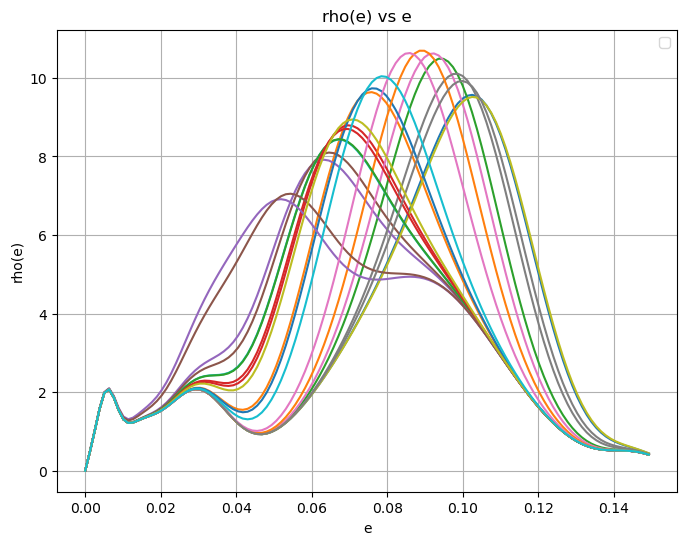

In [3]:
# pattern = '../Perturbed_run_example/Perturbed_TSLs/295.0/leapr/*'
pattern = 'random/pert*.leapr'
temperature = 295.0
file_paths = glob.glob(pattern)

plt.figure(figsize=(8, 6))

for file_path in sorted(file_paths):
        leaprInterface = LeaprInterface.from_file(file_path)
        # perturb_leapr = PerturbLeaprInput(file_path, perturb_params={})
        energy_grid, rho_vals = leaprInterface.Spectrum(temperature)
        plt.plot(energy_grid, rho_vals)

plt.title('rho(e) vs e')
plt.xlabel('e')
plt.ylabel('rho(e)')
plt.grid(True)
plt.legend()
plt.show()

## 2) Processing TSL

In [5]:
perturb_leapr.process(gaiapath = "/home/sole-pie01/codes/gaia2/build/task-manager/src/gaia2_endf.exe", 
                      njoypath = "/home/sole-pie01/codes/NJOY2016/build/njoy",
                      endfpath = "/home/sole-pie01/ndlib/endfb8-neutron/n-001_H_001.endf")

Generated Gaia input file: processing/gaia_input.txt
SLURM not detected. Running locally...
GAIA2-endf version 2.0                                                Sat Jan 18 10:22:32 2025
----------------------------------------------------------------------------------------------
Master says : We have compiled in MPI and run with : 3 available nodes gaia_input.txt 

Checking GAIA2 Input File "gaia_input.txt" ... 
Input check performed successfully.



----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
|                                              GAIA2-ENDF                                    |
|                                               PARALLEL                                     |
----------------------------------------------------------------------------------------------
--------------------------------------------------------------------

### Visualize effect on cross sections

/home/sole-pie01/work/TSL/work/plot_pert_tsl/processing/pendf/test_tsl/sab/h1-h2o_1-test_tsl.295000.pendf
/home/sole-pie01/work/TSL/work/plot_pert_tsl/processing/pendf/test_tsl/sab/h1-h2o_2-test_tsl.295000.pendf


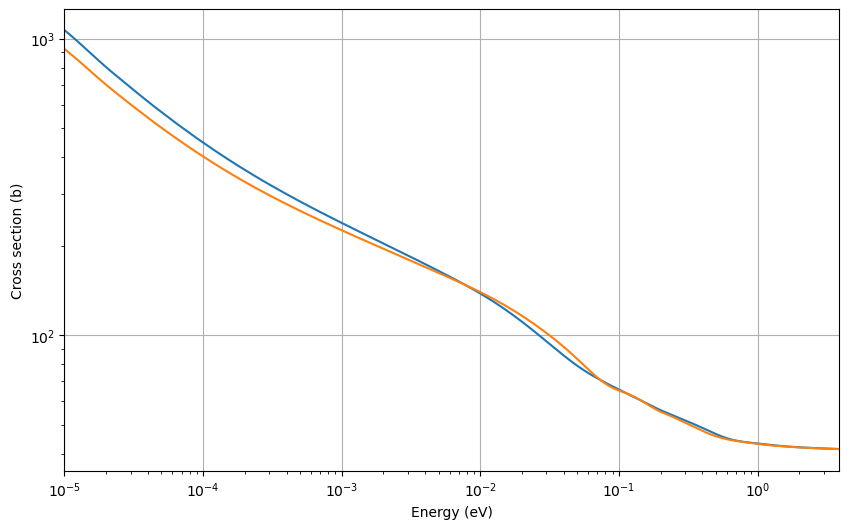

In [8]:
import ENDFtk
import numpy as np
import gc  # Garbage collection module, useful ? IDK
import glob  # For finding files based on a pattern
import matplotlib.pyplot as plt

def plot_data_from_file(pattern):
    file_paths = glob.glob(pattern)

    plt.figure(figsize=(10, 6))

    counter = 0
    for file_path in sorted(file_paths):
        print(file_path)
        try:
            sample_numb = int(file_path.split('/')[-1].split('-')[-1].split('.')[0])
        except ValueError:
            sample_numb = None
            
        tape = ENDFtk.tree.Tape.from_file(file_path)
        MF3 = tape.MAT(tape.material_numbers[0]).file(3).parse()
        en = np.array(MF3.MT(222).energies)
        xs = np.array(MF3.MT(222).cross_sections)
        plt.loglog(en, xs, label=f'HinH2O - (n,inel) - sample {counter}')
        # gc.collect()  # Force garbage collection after processing each file
        counter+=1
        
    # Superpose Free Gaz XS
    # tape = ENDFtk.tree.Tape.from_file( file_paths[0] )
    # MF3 = tape.MAT(tape.material_numbers[0]).file(3).parse()
    # en = np.array(MF3.MT(2).energies)
    # xs = np.array(MF3.MT(2).cross_sections)
        
    # plt.loglog(en, xs, label="HinH2O - (n,inel) - free gaz")

    plt.xlim(1e-5,3.9)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Cross section (b)')
    # plt.legend()
    plt.grid(True) 
    plt.show()
    
# pattern = '/share_snc/LN/SOL_PIERRE/TSL/work/ProcessPerturbedGAIA2/pendf/test_tsl/sab/*'
pattern ='/home/sole-pie01/work/TSL/work/plot_pert_tsl/processing/pendf/test_tsl/sab/*'
plot_data_from_file(pattern)

# Sandbox

In [7]:
import numpy as np
from scipy.stats import qmc
from pyDOE3 import lhs

# Constrained LHS for Weights
def constrained_lhs_weights(n_samples, tbeta_range, twt_range, tw1_range):
    lhs_samples = lhs(2, samples=n_samples)  # Two independent variables
    TBETA = lhs_samples[:, 0] * (tbeta_range[1] - tbeta_range[0]) + tbeta_range[0]
    TWT = lhs_samples[:, 1] * (twt_range[1] - twt_range[0]) + twt_range[0]
    TW1 = np.random.uniform(*tw1_range, size=n_samples)  # Randomly sample TW1
    TW2 = 1 - TBETA - TWT - TW1  # Ensure constraint
    return np.column_stack((TBETA, TWT, TW1, TW2))

# Sobol Sampling for Oscillator Energies
def sobol_sampling_oscillators(n_samples, ranges):
    sampler = qmc.Sobol(d=len(ranges), scramble=True)
    sobol_samples = sampler.random_base2(m=int(np.log2(n_samples)))
    scaled_samples = [
        sobol_samples[:, i] * (ranges[i][1] - ranges[i][0]) + ranges[i][0]
        for i in range(len(ranges))
    ]
    return np.column_stack(scaled_samples)

# Example Inputs
n_samples = 10
oscillator_ranges = [(190, 220), (400, 500)]  # Oscillator energy ranges
tbeta_range = (0.1, 0.2)
twt_range = (0.05, 0.15)
tw1_range = (0.3, 0.5)

# Generate Samples
oscillator_samples = sobol_sampling_oscillators(n_samples, oscillator_ranges)
weights_samples = constrained_lhs_weights(n_samples, tbeta_range, twt_range, tw1_range)

# Verify Samples
print("Oscillator Energies:")
print(oscillator_samples)

# Add last column as the sum of the previous columns
weights_samples = np.column_stack((weights_samples, np.sum(weights_samples, axis=1)))

print("\nWeight Samples with Sum (TBETA, TWT, TW1, TW2, Sum):")
print(weights_samples)

Oscillator Energies:
[[191.44086067 413.03202547]
 [206.32081759 459.66524845]
 [215.32415998 431.98964894]
 [201.14368025 490.63434629]
 [204.6964762  446.65422132]
 [219.3436603  480.68516217]
 [209.8312704  403.06296898]
 [195.4148135  474.30079207]]

Weight Samples with Sum (TBETA, TWT, TW1, TW2, Sum):
[[0.10883219 0.10137027 0.30966661 0.48013093 1.        ]
 [0.1225075  0.08498764 0.41836565 0.37413921 1.        ]
 [0.11000817 0.05930237 0.3796901  0.45099936 1.        ]
 [0.18567101 0.14416754 0.3419853  0.32817615 1.        ]
 [0.15557455 0.07464247 0.43157237 0.3382106  1.        ]
 [0.1436437  0.09616059 0.31548342 0.44471229 1.        ]
 [0.19263412 0.06749791 0.47586162 0.26400634 1.        ]
 [0.17065375 0.13341114 0.46509376 0.23084135 1.        ]
 [0.13874766 0.11337737 0.45787897 0.289996   1.        ]
 [0.16593532 0.12604361 0.44763147 0.26038959 1.        ]]


In [13]:
import numpy as np
from pyDOE3 import lhs

def constrained_lhs(n_samples, variable_ranges):
    """
    Perform constrained LHS sampling for 3 variables where X1 + X2 = 1.

    :param n_samples: Number of samples to generate.
    :param variable_ranges: Ranges for variables (X1, X2, X3).
                            Example: [(0, 1), (0, 1), (0, 1)]
    :return: np.ndarray of shape (n_samples, 3) with sampled points.
    """
    # Ensure variable_ranges has 3 variables
    assert len(variable_ranges) == 3, "Only 3 variables are supported for this constrained LHS."

    # Generate LHS for X1 and X3
    lhs_samples = lhs(2, samples=n_samples)  # Two independent variables: X1 and X3

    # Scale LHS samples to the ranges of X1 and X3
    X1 = lhs_samples[:, 0] * (variable_ranges[0][1] - variable_ranges[0][0]) + variable_ranges[0][0]
    X3 = lhs_samples[:, 1] * (variable_ranges[2][1] - variable_ranges[2][0]) + variable_ranges[2][0]

    # Compute X2 = 1 - X1 to enforce the constraint X1 + X2 = 1
    X2 = 1 - X1

    # Check if X2 is within its range
    assert np.all((X2 >= variable_ranges[1][0]) & (X2 <= variable_ranges[1][1])), \
        "Some X2 values are out of range. Adjust variable_ranges."

    # Combine into the final array
    samples = np.column_stack((X1, X2, X3))

    return samples

def verify_lhs(samples, n_samples):
    """
    Verifies the LHS properties for the given samples.
    :param samples: LHS samples (2D array, shape = (n_samples, n_variables)).
    :param n_samples: Number of strata (and samples).
    :return: True if LHS properties are satisfied, otherwise False.
    """
    n_variables = samples.shape[1] 
    for col in range(n_variables): # Loop Over All Variables
        # Sort the column values into strata indices
        strata_indices = np.floor(samples[:, col] * n_samples).astype(int)
        # Maps the continuous variable values into discrete strata indices. Each value is scaled to its stratum (e.g., 0.3 falls into the 3rd stratum for n_samples=10).
        
        # Check if all strata indices are unique
        if len(set(strata_indices)) != n_samples: # Extracts unique strata indices for the column, there should be 'n_samples' strata
            return False
    return True

n_samples = 10
variable_ranges = [(0, 1), (0, 1), (0, 1)]  # Ranges for X1, X2, X3
samples = constrained_lhs(n_samples, variable_ranges)
# Add last column as the sum of the previous columns
samples = np.column_stack((samples, np.sum(samples, axis=1)))

print("LHS Samples (X1, X2, X3):")
# Print the samples
print(samples)


LHS Samples (X1, X2, X3):
[[0.59503726 0.40496274 0.16797776 1.16797776]
 [0.89793533 0.10206467 0.84869684 1.84869684]
 [0.06073267 0.93926733 0.4918587  1.4918587 ]
 [0.16105706 0.83894294 0.611083   1.611083  ]
 [0.27935416 0.72064584 0.59703844 1.59703844]
 [0.44852585 0.55147415 0.21281515 1.21281515]
 [0.64786962 0.35213038 0.90828353 1.90828353]
 [0.37300809 0.62699191 0.0195912  1.0195912 ]
 [0.76261115 0.23738885 0.76375109 1.76375109]
 [0.98246755 0.01753245 0.37681657 1.37681657]]


In [79]:
print(f"Is the LHS valid? {verify_lhs(samples, n_samples)}")

Is the LHS valid? True


In [78]:
np.sum(samples[:, :2], axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])